In [ ]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [ ]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import datetime

In [ ]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [ ]:
# if COLAB:
#   from google.colab import auth
#   auth.authenticate_user()
# else:
#     print("Run the command!")
#   #Todo #bring the command inside the notebook
#   #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

In [ ]:
try:
  import talib
except:
  #!cp /content/drive/MyDrive/Privat/Crypto/ta-lib-0.4.0-src.tar.gz ta-lib-0.4.0-src.tar.gz
  # !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  #!tar -xzvf ta-lib-0.4.0-src.tar.gz
  !unzip /content/drive/MyDrive/Privat/Crypto/talibmaked.zip -d /
  %cd ta-lib
  #!./configure --prefix=/usr
  #!make
  !make install
  !pip install Ta-Lib
  %cd /content
  
  import talib
  from talib import MA_Type

In [ ]:
import numpy as np
import json
from tqdm import tqdm
import copy
import pandas as pd
import os
from functools import partial
from threading import Thread
import time
import random

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
MAKER_FEE_PERCENT = 3.3 # 6,75 Einstiegskosten, 0.55% pro Jahr, 6,75 Ausstiegskosten,
MAKER_FEE_FACTOR = MAKER_FEE_PERCENT / 100.0
MAKER_FEE_FACTOR

0.033

In [ ]:
BUYSELL_GLITCH_PERCENT = 0.1 #1
BUYSELL_GLITCH_FACTOR = BUYSELL_GLITCH_PERCENT / 100.0
BUYSELL_GLITCH_FACTOR

0.001

In [ ]:
INDICATOR_MA_PERIOD = 7
# INDICATOR_ROC_PERIOD = 6
INDICATOR_MINMAX_PERIOD = 1*28

In [ ]:
# Define a global random seed
RANDOM_SEED = 42+3

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [ ]:
# # ETF_1
MODEL_SHORTHAND = "ETF_1"

# if COLAB:
#   BASE_PATH1 = "/content/PastFutureGainV2/test"
# else:
#   BASE_PATH1 = "/content/dataset/etffancy/PastFutureGainV2/test"
# BASE_PATH1 = "/content/dataset/etffancy/PastFutureGainV2/timeBasedEval5"

In [ ]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [ ]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


In [ ]:
onlyfiles = TRAIN_FILES

In [ ]:
MODEL_TEST_CONSTALLATION_INDEX = 1

In [ ]:
# RESULTS_DIR = BASE_PATH1.replace("predicted", "results")
# RESULTS_DIR = RESULTS_DIR + f"_{MODEL_SHORTHAND}_{MODEL_TEST_CONSTALLATION_INDEX}"
RESULTS_DIR = "/content/results" + f"_{MODEL_SHORTHAND}_{MODEL_TEST_CONSTALLATION_INDEX}"

if not os.path.exists(RESULTS_DIR):
  os.mkdir(RESULTS_DIR)

RESULTS_DIR

'/content/results_ETF_1_1'

# Load data

In [ ]:
onlyfiles[:5]

['/content/dataset/etffancy/IE00BDFC6Q91.csv',
 '/content/dataset/etffancy/IE00B3B8PX14.csv',
 '/content/dataset/etffancy/LU2037748345.csv',
 '/content/dataset/etffancy/LU1327051279.csv',
 '/content/dataset/etffancy/IE00B1FZS350.csv']

# Ground truth y calculation

In [ ]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [ ]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

In [ ]:
# Set direction and derivation information as y target
# Both y values (direction & derivation) are in the interval [-1.0,1.0]

Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_TYPE_DICT["direction_ma_timespan"] = 75
Y_TYPE_DICT["derivation_ma_timespan"] = 40
Y_TYPE_DICT

{'dataType': 0,
 'direction_ma_timespan': 75,
 'derivation_ma_timespan': 40,
 'direction_derivation_shift_span': 0}

In [ ]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

In [ ]:
fn = onlyfiles[0]

_tbl = pd.read_csv(fn)
_tbl.set_index("startsAt", inplace=True)
_tbl.sort_index(inplace=True)
_tbl

,open,high,low,close,volume,quoteVolume
startsAt,,,,,,
1518652800,80.04,80.04,80.04,80.04,0.0,0.0
1518739200,80.25,80.25,80.25,80.25,0.0,0.0
1518825600,80.25,80.25,80.25,80.25,0.0,0.0
1518912000,80.25,80.25,80.25,80.25,0.0,0.0
1518998400,80.60,80.60,80.60,80.60,0.0,0.0
...,...,...,...,...,...,...
1676851200,102.99,102.99,102.99,102.99,0.0,0.0
1676937600,103.07,103.07,103.07,103.07,0.0,0.0
1677024000,103.27,103.27,103.27,103.27,0.0,0.0


In [ ]:
# A python generator function has to be applied on the dataStream

def yGroundTruthGen(csvPath):
  # Load the tick table to get its lenght
  tbl = pd.read_csv(csvPath)
  tableLen = tbl.shape[0]

  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = [csvPath],
                                                      batch_size = tableLen-2, # 2 has to be substracted, else an File list is empty (second check) error occurs
                                                      X_Block_lenght = 2,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  ne = next(dataStreamTraining)

  y = np.zeros((tbl.shape[0], ne['y'].shape[1]))
  y[-ne['y'].shape[0]:] = ne['y'] 

  return y

yGTData = yGroundTruthGen(onlyfiles[0])
yGTData.shape

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 0 left


(1836, 2)

# Type 2

In [ ]:
# Set direction and derivation information as y target
# Both y values (direction & derivation) are in the interval [-1.0,1.0]

Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 2*30
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [ ]:
# A python generator function has to be applied on the dataStream

def yGroundTruthGen(csvPath):
  # Load the tick table to get its lenght
  tbl = pd.read_csv(csvPath)
  tbl.set_index("startsAt", inplace=True)
  tbl.sort_index(inplace=True)
  tableLen = tbl.shape[0]

  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = [csvPath],
                                                      batch_size = tableLen-2, # 2 has to be substracted, else an File list is empty (second check) error occurs
                                                      X_Block_lenght = 2,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  ne = next(dataStreamTraining)

  y = np.zeros((tbl.shape[0], ne['y'].shape[1]))
  y[-ne['y'].shape[0]:] = ne['y'] 

  return y, tbl

yGTData, fancyTickTbl = yGroundTruthGen(onlyfiles[0])
yGTData.shape

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 0 left


(1836, 4)

In [ ]:
fancyTickTbl.shape

(1836, 6)

In [ ]:
yGTData.shape

(1836, 4)

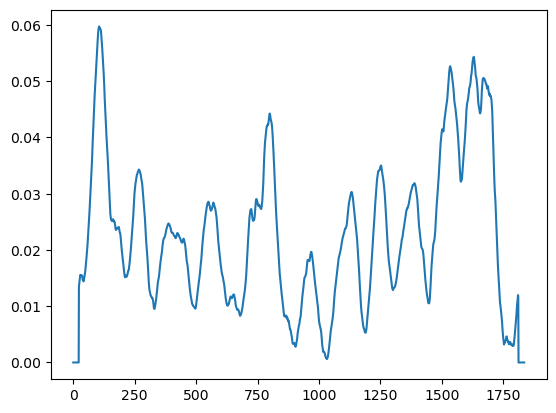

In [ ]:
plt.plot(yGTData[:,0])

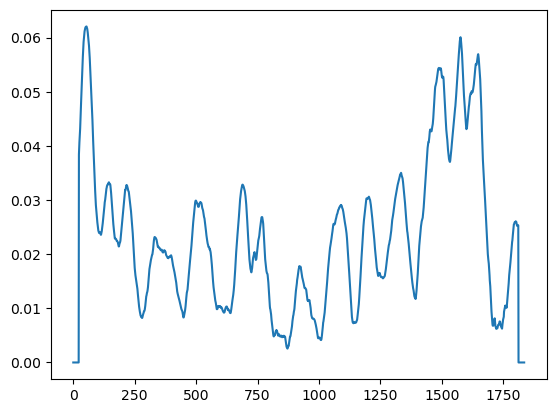

In [ ]:
plt.plot(yGTData[:,1])

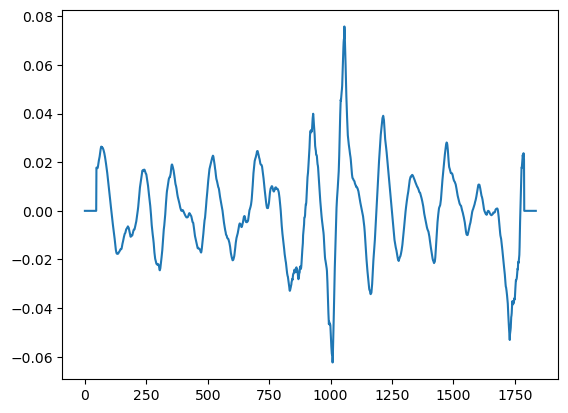

In [ ]:
plt.plot(yGTData[:,2])

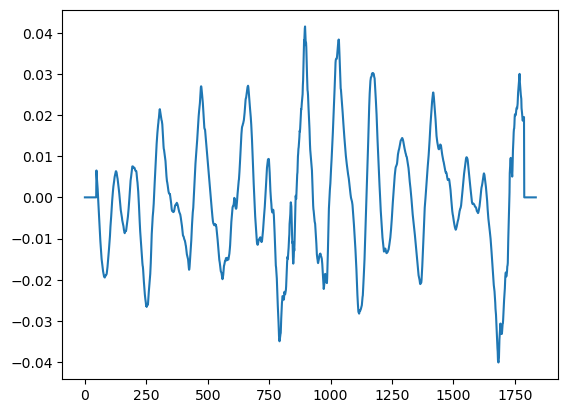

In [ ]:
plt.plot(yGTData[:,3])

In [ ]:
#@title AddPeriodIndicator
def AddPeriodIndicator(tblIn, featureName):
  values = tblIn.loc[:,featureName].values

  valuesMAd = talib.MA(values.astype(float), timeperiod=INDICATOR_MA_PERIOD)

  tblIn.loc[:, featureName + '_span'] = valuesMAd

  return tblIn

In [ ]:
#@title AddHistoricalMinMax
def AddHistoricalMinMax(tblIn, featureName):
  values = tblIn.loc[:,featureName].values

  # # Shift the values to get on the historical max and not include the current value
  # values_shifted = np.empty(values.shape)
  # values_shifted[:] = np.nan
  # values_shifted[1:] = values[:-1]

  # Do not Shift the values to get on the historical max, to include the current value
  values_shifted = values

  valuesMIN = talib.MIN(values_shifted.astype(float), timeperiod=INDICATOR_MINMAX_PERIOD)
  valuesMAX = talib.MAX(values_shifted.astype(float), timeperiod=INDICATOR_MINMAX_PERIOD)

  tblIn.loc[:, featureName + '_min'] = valuesMIN
  tblIn.loc[:, featureName + '_max'] = valuesMAX

  return tblIn

In [ ]:
#@title AddPrefValues
def AddPrefValues(tblIn, featureName):
  values = tblIn.loc[:, featureName].values

  shifted_values = np.empty(values.shape)
  shifted_values[:] = np.nan
  shifted_values[1:] = values[:-1]

  tblIn.loc[:, featureName + '_previous'] = shifted_values

  return tblIn

In [ ]:
#@title Add24hPercentChangeToTbl
def Add24hPercentChangeToTbl(tblIn):
  close = tblIn.loc[:,'close']
  close_values = close.values

  close_previous_values = np.zeros(close_values.shape)
  close_previous_values[24:] = close_values[:-24]
  close_previous_values

  change = ((close_values / close_previous_values) - 1.0) * 100.0
  change = np.nan_to_num(change, nan=0.0, posinf=0.0, neginf=0.0)

  tblIn.loc[:,'24h_percent_change'] = change

  return tblIn

In [ ]:
#@title AddWMAIndicator
def AddWMAIndicator(tblIn, featureName):
  values = tblIn.loc[:,featureName].values

  valuesMAd = talib.WMA(values.astype(float), timeperiod=INDICATOR_MA_PERIOD)

  tblIn.loc[:, featureName + '_wma' + str(INDICATOR_MA_PERIOD)] = valuesMAd

  return tblIn

In [ ]:
# FIRST_INDICATOR_NAME = "p_future_gain"
# SECOND_INDICATOR_NAME = "p_past_gain"
FIRST_INDICATOR_NAME = "gt_past_gain"
SECOND_INDICATOR_NAME = "gt_future_gain"
THIRD_INDICATOR_NAME = "gt_past_gain_derivation"
FOURTH_INDICATOR_NAME = "gt_future_gain_derivation"

In [ ]:
yGTData

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
# onlyfiles = onlyfiles[:5]

In [ ]:
tbls_dict = {}

for fn in tqdm(onlyfiles):
  # Add y ground truth data to the table
  yGTData, _tbl = yGroundTruthGen(fn)
  _tbl["gt_past_gain"] = yGTData[:,0]
  _tbl["gt_future_gain"] = yGTData[:,1]
  _tbl["gt_past_gain_derivation"] = yGTData[:,2]
  _tbl["gt_future_gain_derivation"] = yGTData[:,3]

  try:
    for indName in [FIRST_INDICATOR_NAME, SECOND_INDICATOR_NAME, THIRD_INDICATOR_NAME, FOURTH_INDICATOR_NAME]:
      _tbl = AddHistoricalMinMax(_tbl, indName)
      _tbl = AddPrefValues(_tbl, f"{indName}_min")      
      _tbl = AddPrefValues(_tbl, f"{indName}_max")
      
      _tbl = AddPrefValues(_tbl, indName)
      
      _tbl = AddPeriodIndicator(_tbl, indName)
      _tbl = AddPrefValues(_tbl, f"{indName}_span")
      
      _tbl = AddHistoricalMinMax(_tbl, indName)      

    _tbl = AddHistoricalMinMax(_tbl, "open")
    _tbl = AddPrefValues(_tbl, "open")  
    _tbl = Add24hPercentChangeToTbl(_tbl)
  except KeyError as kex:
    print(kex)
    continue
  
  _curr = fn.split("/")[-1].split(".")[0]

  tbls_dict[_curr] = _tbl

  0%|                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]INFO:root:File 'IE00BDFC6Q91.csv' loaded, 0 left
/tmp/ipykernel_44/3984444837.py:10: RuntimeWarning: divide by zero encountered in divide
  change = ((close_values / close_previous_values) - 1.0) * 100.0
 20%|████████████████████████████████████████▌                                                                                                                                                                  | 1/5 [00:00<00:03,  1.24it/s]INFO:root:File 'IE00B3B8PX14.csv' loaded, 0 left
/tmp/ipykernel_44/3984444837.py:10: RuntimeWarning: divide by zero encountered in divide
  change = ((close_values / close_previous_values) - 1.0) * 100.0
 40%|█████████████████████████████████████████████████████████████████████████████████▏                             

In [ ]:
_tbl

,open,high,low,close,volume,quoteVolume,gt_past_gain,gt_future_gain,gt_past_gain_derivation,gt_future_gain_derivation,...,gt_future_gain_derivation_max,gt_future_gain_derivation_min_previous,gt_future_gain_derivation_max_previous,gt_future_gain_derivation_previous,gt_future_gain_derivation_span,gt_future_gain_derivation_span_previous,open_min,open_max,open_previous,24h_percent_change
startsAt,,,,,,,,,,,,,,,,,,,,,
1217548800,80.95,80.95,80.95,80.95,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1217635200,80.95,80.95,80.95,80.95,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,80.95,0.000000
1217721600,80.95,80.95,80.95,80.95,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,80.95,0.000000
1217808000,81.11,81.11,81.11,81.11,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,80.95,0.000000
1217894400,81.10,81.10,81.10,81.10,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,81.11,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676851200,140.38,140.38,140.38,140.38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.685160e-17,-1.685160e-17,140.24,142.24,140.91,-1.154767
1676937600,140.07,140.07,140.07,140.07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.685160e-17,-1.685160e-17,140.07,142.19,140.38,-1.373046
1677024000,140.11,140.11,140.11,140.11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.685160e-17,-1.685160e-17,140.07,142.02,140.07,-1.344881


IE00B3B8PX14


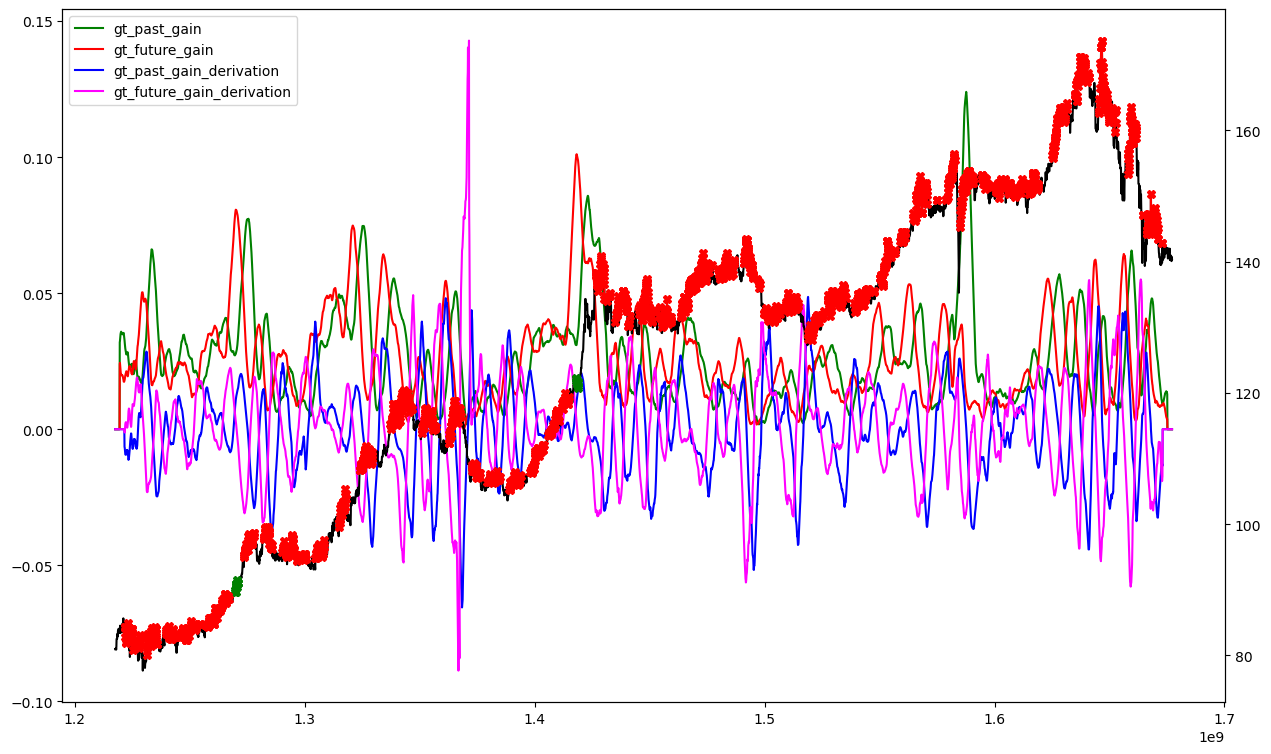

In [ ]:
entryThr1 = 0.005 # Range from 0.00 to 0.03
entryThr2 = 0.075 # Range from 0.075 to 0.125

exitThr1 = 0.050 # Range from 0.00 to 0.03
exitThr2 = 0.045 # Range from 0.025 to 0.05

cur = list(tbls_dict.keys())[1]
print(cur)
_tbl = tbls_dict[cur]

fig, ax1 = plt.subplots(figsize=(15,9))

ax1.plot(_tbl.loc[:,FIRST_INDICATOR_NAME], color="green", label=FIRST_INDICATOR_NAME)
ax1.plot(_tbl.loc[:,SECOND_INDICATOR_NAME], color="red", label=SECOND_INDICATOR_NAME)
ax1.plot(_tbl.loc[:,THIRD_INDICATOR_NAME], color="blue", label=THIRD_INDICATOR_NAME)
ax1.plot(_tbl.loc[:,FOURTH_INDICATOR_NAME], color="magenta", label=FOURTH_INDICATOR_NAME)

ax2 = ax1.twinx()
ax2.plot(_tbl.loc[:,'open'], color = "black")

# Entry: Future gain derivation shall be falling
entrySignals = (_tbl.loc[:,f'{FOURTH_INDICATOR_NAME}_previous'] > _tbl.loc[:,f'{FOURTH_INDICATOR_NAME}']) & (_tbl.loc[:,f'{FOURTH_INDICATOR_NAME}'] <= entryThr1) & (_tbl.loc[:,f'{FOURTH_INDICATOR_NAME}'] >= -1.0 * entryThr1) & (_tbl.loc[:,f'{SECOND_INDICATOR_NAME}'] >= entryThr2)
entrySignals[entrySignals == 0.0] = np.nan

# Exit
exitSignals = (_tbl.loc[:,f'{THIRD_INDICATOR_NAME}_previous'] > _tbl.loc[:,f'{THIRD_INDICATOR_NAME}']) & (_tbl.loc[:,f'{THIRD_INDICATOR_NAME}'] <= exitThr1) & (_tbl.loc[:,f'{THIRD_INDICATOR_NAME}'] >= -1.0 * exitThr1) & (_tbl.loc[:,f'{SECOND_INDICATOR_NAME}'] <= exitThr2)
exitSignals[exitSignals == 0.0] = np.nan

ax2.plot(entrySignals * _tbl.loc[:,'open'], marker="X", color="green")
ax2.plot(exitSignals * _tbl.loc[:,'open'], marker="X", color="red")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Check if the DataStreamCreator calculates it right

In [ ]:
# Set direction and derivation information as y target
# Both y values (direction & derivation) are in the interval [-1.0,1.0]

Y_TYPE_DICT_CHECK = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN_BASED_TRADE_SIGNALS)
Y_TYPE_DICT_CHECK

{'dataType': 4,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48,
 'entryThr1': 0.005,
 'entryThr2': 0.075,
 'exitThr1': 0.05,
 'exitThr2': 0.045}

In [ ]:
# A python generator function has to be applied on the dataStream

def yCheckGen(csvPath):
  # Load the tick table to get its lenght
  tbl = pd.read_csv(csvPath)
  tbl.set_index("startsAt", inplace=True)
  tbl.sort_index(inplace=True)
  tableLen = tbl.shape[0]

  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = [csvPath],
                                                      batch_size = tableLen-2, # 2 has to be substracted, else an File list is empty (second check) error occurs
                                                      X_Block_lenght = 2,
                                                      y_type_dict=Y_TYPE_DICT_CHECK,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  ne = next(dataStreamTraining)

  y = np.zeros((tbl.shape[0], ne['y'].shape[1]))
  y[-ne['y'].shape[0]:] = ne['y'] 

  return y, tbl

yCheckData, fancyTickTbl = yCheckGen(onlyfiles[1])
yCheckData.shape

INFO:root:File 'IE00B3B8PX14.csv' loaded, 0 left


(5321, 3)

In [ ]:
_tbl.shape

(5321, 42)

In [ ]:
entrySignals

startsAt
1217548800    NaN
1217635200    NaN
1217721600    NaN
1217808000    NaN
1217894400    NaN
             ... 
1676851200    NaN
1676937600    NaN
1677024000    NaN
1677110400    NaN
1677196800    NaN
Length: 5321, dtype: object

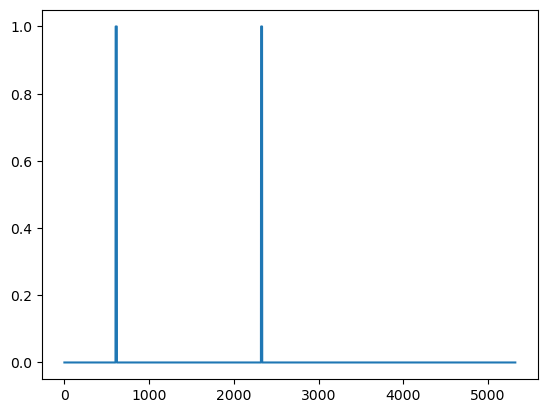

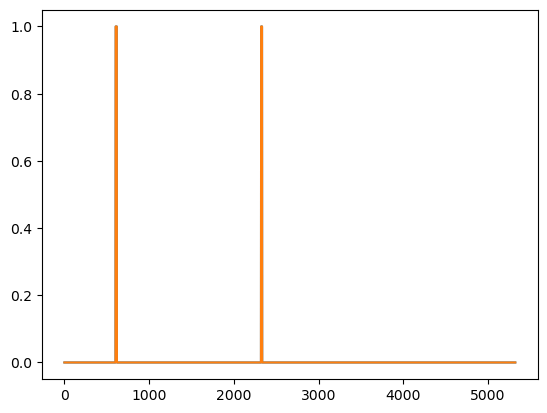

In [ ]:
entryVal = entrySignals.values.astype(float)
entryVal = np.nan_to_num(entryVal,0,0,0)

entryVal

plt.plot(yCheckData[:,0])
plt.plot(entryVal)

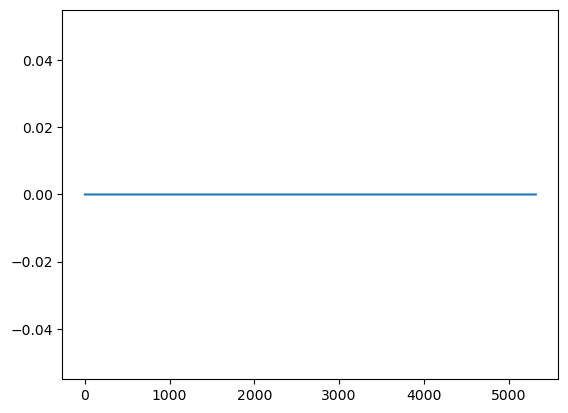

In [ ]:
plt.plot(yCheckData[:,0] - entryVal)

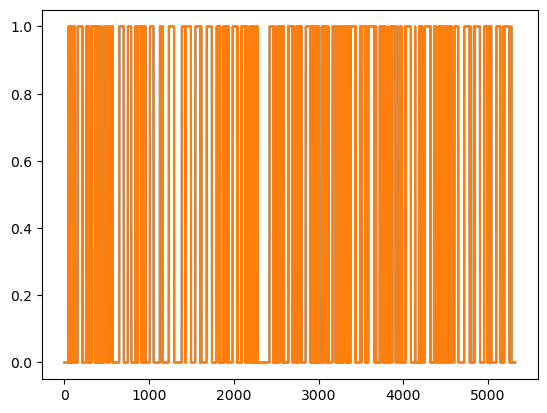

In [ ]:
exitVal = exitSignals.values.astype(float)
exitVal = np.nan_to_num(exitVal,0,0,0)

plt.plot(yCheckData[:,1])
plt.plot(exitVal)

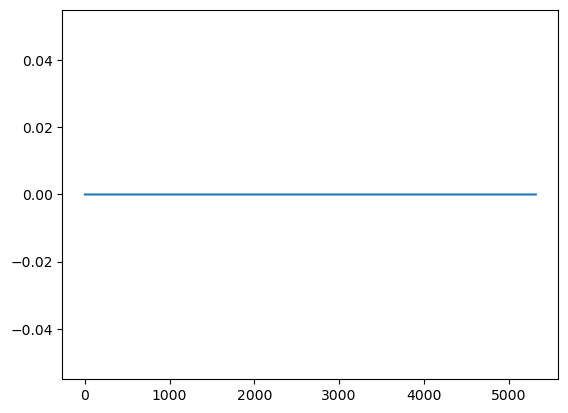

In [ ]:
plt.plot(yCheckData[:,1] - exitVal)

In [ ]:
stop

# Get X and y data for entry exit training

In [ ]:
tickDFforXy = copy.deepcopy(tbls_dict[list(tbls_dict.keys())[9]])
tickDFforXy.dropna(inplace=True)
tickDFforXy

,open,high,low,close,volume,quoteVolume,gt_past_gain,gt_future_gain,gt_past_gain_derivation,gt_future_gain_derivation,...,gt_future_gain_derivation_max,gt_future_gain_derivation_min_previous,gt_future_gain_derivation_max_previous,gt_future_gain_derivation_previous,gt_future_gain_derivation_span,gt_future_gain_derivation_span_previous,open_min,open_max,open_previous,24h_percent_change
startsAt,,,,,,,,,,,,,,,,,,,,,
1230249600,31.58,31.58,31.58,31.58,0.0,0.0,0.064352,0.069511,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,30.61,34.11,31.58,-0.378549
1230336000,31.58,31.58,31.58,31.58,0.0,0.0,0.064804,0.069242,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,30.61,34.11,31.58,-3.336394
1230422400,31.58,31.58,31.58,31.58,0.0,0.0,0.064377,0.069899,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,30.61,34.11,31.58,-3.247549
1230508800,31.05,31.05,31.05,31.05,0.0,0.0,0.063984,0.070526,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,30.61,33.53,31.58,-4.107474
1230595200,32.03,32.03,32.03,32.03,0.0,0.0,0.063932,0.070780,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,30.61,33.53,31.05,-1.080914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676851200,125.82,125.82,125.82,125.82,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,-4.014646e-17,-4.014646e-17,122.61,126.28,126.05,1.508673
1676937600,125.28,125.28,125.28,125.28,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,-4.014646e-17,-4.014646e-17,122.61,126.28,125.82,1.073013
1677024000,124.09,124.09,124.09,124.09,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,-4.014646e-17,-4.014646e-17,123.07,126.28,125.28,0.112949


In [ ]:
for index, row in tickDFforXy.iterrows():
  print(row)
  break

open                                       31.580000
high                                       31.580000
low                                        31.580000
close                                      31.580000
volume                                      0.000000
quoteVolume                                 0.000000
gt_past_gain                                0.064352
gt_future_gain                              0.069511
gt_past_gain_derivation                     0.000000
gt_future_gain_derivation                   0.000000
gt_past_gain_min                            0.000000
gt_past_gain_max                            0.064352
gt_past_gain_min_previous                   0.000000
gt_past_gain_max_previous                   0.061839
gt_past_gain_previous                       0.061839
gt_past_gain_span                           0.052541
gt_past_gain_span_previous                  0.043348
gt_future_gain_min                          0.000000
gt_future_gain_max                          0.

In [ ]:
def CalcEntrySignals(tbl, entryThr1, entryThr2, entryThr3):

  # entrySignals = (tbl.loc[:,f'{FOURTH_INDICATOR_NAME}_previous'] > tbl.loc[:,f'{FOURTH_INDICATOR_NAME}']) & (tbl.loc[:,f'{FOURTH_INDICATOR_NAME}'] <= entryThr1) & (tbl.loc[:,f'{FOURTH_INDICATOR_NAME}'] >= entryThr2)
  entrySignals = (tbl.loc[:,f'{FOURTH_INDICATOR_NAME}_previous'] > tbl.loc[:,f'{FOURTH_INDICATOR_NAME}']) & (tbl.loc[:,f'{FOURTH_INDICATOR_NAME}'] <= entryThr1) & (tbl.loc[:,f'{FOURTH_INDICATOR_NAME}'] >= -1.0 * entryThr1) & (tbl.loc[:,f'{SECOND_INDICATOR_NAME}'] >= entryThr2)

  tbl['entry_signal'] = entrySignals

  return tbl

In [ ]:
def CalcExitSignals(tbl, exitThr1, exitThr2):

  # ETF_1

  # exitSignals = (tbl.loc[:,f'{THIRD_INDICATOR_NAME}_previous'] > tbl.loc[:,f'{THIRD_INDICATOR_NAME}']) & (tbl.loc[:,f'{THIRD_INDICATOR_NAME}'] <= exitThr1) & (tbl.loc[:,f'{THIRD_INDICATOR_NAME}'] >= exitThr2)
  exitSignals = (tbl.loc[:,f'{THIRD_INDICATOR_NAME}_previous'] > tbl.loc[:,f'{THIRD_INDICATOR_NAME}']) & (tbl.loc[:,f'{THIRD_INDICATOR_NAME}'] <= exitThr1) & (tbl.loc[:,f'{THIRD_INDICATOR_NAME}'] >= -1.0 * exitThr1) & (tbl.loc[:,f'{SECOND_INDICATOR_NAME}'] <= exitThr2)
  
  tbl['exit_signal'] = exitSignals

  return tbl

In [ ]:
TRADE_SIGNAL_EXIT = 0
TRADE_SIGNAL_ENTRY = 1
TRADE_SIGNAL_HODL_EXIT = 2
TRADE_PRICE_BASIS = "open"

In [ ]:
#@title CreateEntrySignalDict
def CreateEntrySignalDict(tickAndSignalsDF):
  global TRADE_SIGNAL_ENTRY
  global TRADE_PRICE_BASIS

  # Get the entry indices (only where entry is true)
  entry_indices = np.array(tickAndSignalsDF[True == tickAndSignalsDF["entry_signal"]].index)

  # Shift the indices forward one timestep to the price, as the trade can only be done in the next tick after creating the signal
  timestep_spread = tickAndSignalsDF.index[1] - tickAndSignalsDF.index[0]
  shifted_entry_indices = entry_indices + timestep_spread
  shifted_entry_indices = shifted_entry_indices[shifted_entry_indices <= np.max(tickAndSignalsDF.index)]

  # Get the entry prices
  entry_prices = np.array(tickAndSignalsDF.loc[shifted_entry_indices, TRADE_PRICE_BASIS])

  entry_dicts = []

  for i, entry_index in enumerate(shifted_entry_indices):
    entry_dict = {
        "tradeSignal": TRADE_SIGNAL_ENTRY,
        "index": entry_index,
        "price": entry_prices[i]
    }

    entry_dicts.append(entry_dict)

  return entry_dicts

In [ ]:
#@title CreateHodlTimeExitSignalDict
def CreateHodlTimeExitSignalDict(tickAndSignalsDF, maxHodlTimeSeconds, entrySignalsDict):
  global TRADE_SIGNAL_HODL_EXIT
  global TRADE_PRICE_BASIS

  # Add the max_hodl_time to the entry indices to get the latest exit points
  # Todo important: Check if the indices acutally exist in the table (maybe off some seconds, maybe over the end)

  # Todo: Add a check if maxHodlTimeSeconds % tickTimeSpan is zero

  entry_indices = np.array(list(map(lambda d: d["index"], entrySignalsDict)))

  hodl_exit_indices = entry_indices + maxHodlTimeSeconds

  # Shift the indices forward one timestep to the price, as the trade can only be done in the next tick after creating the signal
  timestep_spread = tickAndSignalsDF.index[1] - tickAndSignalsDF.index[0]
  shifted_hodl_exit_indices = hodl_exit_indices + timestep_spread
  shifted_hodl_exit_indices = shifted_hodl_exit_indices[shifted_hodl_exit_indices <= np.max(tickAndSignalsDF.index)]

  # Get the hodl exit prices
  hodl_exit_prices = np.array(tickAndSignalsDF.loc[shifted_hodl_exit_indices, TRADE_PRICE_BASIS])

  hodl_exit_dicts = []

  # Check if the index and price array are the same size
  # Maybe not, this occurs if a price could not be gathered due to be out of the DFs timeframe
  if hodl_exit_indices.shape == hodl_exit_prices.shape:
    for i, hodl_exit_index in enumerate(shifted_hodl_exit_indices):
      hodl_exit_dict = {
          "tradeSignal": TRADE_SIGNAL_HODL_EXIT,
          "index": hodl_exit_index,
          "entry_index": entry_indices[i],
          "price": hodl_exit_prices[i]
      }

      hodl_exit_dicts.append(hodl_exit_dict)

  return hodl_exit_dicts

In [ ]:
#@title CreateExitSignalDict
def CreateExitSignalDict(tickAndSignalsDF, exitOnLastTick = True):
  global TRADE_SIGNAL_ENTRY
  global TRADE_PRICE_BASIS

  # Get the normal exit indices
  exit_indices = np.array(tickAndSignalsDF[True == tickAndSignalsDF["exit_signal"]].index)

  # Shift the indices forward one timestep to the price, as the trade can only be done in the next tick after creating the signal
  timestep_spread = tickAndSignalsDF.index[1] - tickAndSignalsDF.index[0]
  shifted_exit_indices = exit_indices + timestep_spread
  shifted_exit_indices = shifted_exit_indices[shifted_exit_indices <= np.max(tickAndSignalsDF.index)]

  if exitOnLastTick:
    maxIndex = np.max(tickAndSignalsDF.index)
    if not maxIndex in shifted_exit_indices:
      shifted_exit_indices = np.append(shifted_exit_indices, maxIndex)

  # Get the exit prices
  exit_prices = np.array(tickAndSignalsDF.loc[shifted_exit_indices, TRADE_PRICE_BASIS])

  exit_dicts = []

  for i, exit_index in enumerate(shifted_exit_indices):
    exit_dict = {
        "tradeSignal": TRADE_SIGNAL_EXIT,
        "index": exit_index,
        "price": exit_prices[i]
    }

    exit_dicts.append(exit_dict)

  return exit_dicts

In [ ]:
#@title TraderV2
def TraderV2(tickDF, entryThr1, entryThr2, exitThr1, exitThr2, maxHodlTimeSeconds, **kwargs):
  global SIGNAL_OPERATORS
  global SIGNAL_INDICATORS

  trades = []
  current_trade = None

  hodl_exit_count = 0

  # Fees to simulate real trading
  makerFeeFactor = 0.0
  buySellGlitchFactor = 0.0
  hodlPenaltyFactor = 0.0

  # Parse kwargs
  if "makerFeeFactor" in kwargs.keys():
    makerFeeFactor = float(kwargs["makerFeeFactor"])
  if "buySellGlitchFactor" in kwargs.keys():
    buySellGlitchFactor = float(kwargs["buySellGlitchFactor"])
  if "hodlPenaltyFactor" in kwargs.keys():
    hodlPenaltyFactor = float(kwargs["hodlPenaltyFactor"])

  # A template for a trade
  trade_template = {
      'gain': 0.0,
      'hodl_time': 0.0,
      'in_timestamp': 0.0,
      'in_price': 0.0,
      'out_timestamp': 0.0,
      'out_price': 0.0,
      'exit_cond_hodl_time': False                  
  }

  # Calculate the signals
  tickAndSignalsDF = copy.deepcopy(tickDF)

  #tickAndSignalsDF = CalcMatrixBasedSignals(tickAndSignalsDF, entryThresholdMatrix, entryWeightMatrix, SIGNAL_OPERATORS, SIGNAL_INDICATORS, direction="entry_signal")
  #tickAndSignalsDF = CalcMatrixBasedSignals(tickAndSignalsDF, exitThresholdMatrix, exitWeightMatrix, SIGNAL_OPERATORS, SIGNAL_INDICATORS, direction="exit_signal")

  tickAndSignalsDF = CalcEntrySignals(tickAndSignalsDF, entryThr1, entryThr2, 0)
  tickAndSignalsDF = CalcExitSignals(tickAndSignalsDF, exitThr1, exitThr2)

  # Entry and exit cannot be active at the same time, if this would happen, keep just the exit
  tickAndSignalsDF.loc[(tickAndSignalsDF["entry_signal"] == True) & (tickAndSignalsDF["exit_signal"] == True), "entry_signal"] = False

  # Extract the signals from the DF
  entrySignalsDict = CreateEntrySignalDict(tickAndSignalsDF)
  exitSignalsDict = CreateExitSignalDict(tickAndSignalsDF)
  hodlTimeExitSignalsDict = CreateHodlTimeExitSignalDict(tickAndSignalsDF, maxHodlTimeSeconds, entrySignalsDict)

  # Merge the signals and sort the list by index (== timestamp)
  all_signals = entrySignalsDict + exitSignalsDict + hodlTimeExitSignalsDict
  all_signals = sorted(all_signals, key=lambda d: d["index"])

  # Go through the trade signals and trade
  for i, signal in enumerate(all_signals):
    # Entry signal
    if TRADE_SIGNAL_ENTRY == signal["tradeSignal"]:
      if current_trade is None:
        current_trade = copy.deepcopy(trade_template)
        current_trade["in_timestamp"] = signal["index"]
        current_trade["in_price"] = signal["price"]
    
    # Exit signals
    elif TRADE_SIGNAL_EXIT == signal["tradeSignal"] or TRADE_SIGNAL_HODL_EXIT == signal["tradeSignal"]:
      if not current_trade is None:
        # If it is a hodl exit, the entry time in the hodl exit signal has to match the current trade's entry time; Otherwise, the trade would already be over
        if TRADE_SIGNAL_HODL_EXIT == signal["tradeSignal"]:
          if current_trade["in_timestamp"] != signal["entry_index"]:
            continue

        current_trade["out_timestamp"] = signal["index"]
        current_trade["out_price"] = signal["price"]

        current_trade["hodl_time"] = current_trade["out_timestamp"] - current_trade["in_timestamp"]
        current_trade["gain"] = (current_trade["out_price"] / current_trade["in_price"]) - 1.0 - 2.0*makerFeeFactor - 2.0*buySellGlitchFactor - hodlPenaltyFactor

        # Set the hodl time exit flag
        current_trade["exit_cond_hodl_time"] = True if TRADE_SIGNAL_HODL_EXIT == signal["tradeSignal"] else False

        trades.append(copy.deepcopy(current_trade))
        current_trade = None

  # Sum gain
  sum_gain = 0.0
  for t in trades:
    sum_gain += t['gain']

  # Mult gain
  mult_gain = 1.0
  for t in trades:
    mult_gain *= (1.0 + t['gain'])      
  mult_gain -= 1.0 

  # Pos Neg Trades
  pos_tr = 0
  neg_tr = 0
  for t in trades:
    if 0 < t['gain']:
      pos_tr += 1
    else:
      neg_tr += 1

  # Pos Neg Trades hodl exit
  pos_tr_hodlexit = 0
  neg_tr_hodlexit = 0
  for t in trades:
    if t['exit_cond_hodl_time']:
      if 0 < t['gain']:
        pos_tr_hodlexit += 1
      else:
        neg_tr_hodlexit += 1

  # Pending sell
  pending_sell = 0
  if not current_trade is None:
    pending_sell = 1  

  summary_dict = {
      'sum_gain': sum_gain,
      'mult_gain': mult_gain,
      'trades': trades,
      'pos_tr': pos_tr,
      'neg_tr': neg_tr,
      'pos_tr_hodlexit': pos_tr_hodlexit,
      'neg_tr_hodlexit': neg_tr_hodlexit,
      'pending_sell': pending_sell,
      'hodl_exit_count': hodl_exit_count
  }

  return summary_dict

In [ ]:
#@title CalculateTradeParameterMetrics
def CalculateTradeParameterMetrics(tradesSummaryDict):
  gains_list = []

  all_sum_gain = 0.0
  all_mult_gain = 0.0
  all_sum_gain_clean = 0.0
  all_mult_gain_clean = 0.0
  all_pos_tr = 0
  all_neg_tr = 0
  all_pos_tr_hodlexit = 0
  all_neg_tr_hodlexit = 0
  all_pending_sell = 0
  all_hodl_exit_count = 0
  all_trl_exits = 0
  all_sl_exits = 0

  if 0 == len(gains_list):
    gains_list.append(0)

  q01 = np.quantile(gains_list, 0.01)
  q99 = np.quantile(gains_list, 0.99)

  # Sum gain clean (this mean within the quantiles)
  sum_gain_clean = 0.0
  for g in gains_list:
    if q01 <= g and q99 >= g:
      sum_gain_clean += g

  # Mult gain
  mult_gain_clean = 1.0
  for g in gains_list:
    if q01 <= g and q99 >= g:
      mult_gain_clean *= (1.0 + g)      
  mult_gain_clean -= 1.0

  for k in tradesSummaryDict:
    all_sum_gain += tradesSummaryDict[k]['sum_gain']
    all_mult_gain += tradesSummaryDict[k]['mult_gain']
    all_pos_tr += tradesSummaryDict[k]['pos_tr']
    all_neg_tr += tradesSummaryDict[k]['neg_tr']
    all_pos_tr_hodlexit += tradesSummaryDict[k]['pos_tr_hodlexit']
    all_neg_tr_hodlexit += tradesSummaryDict[k]['neg_tr_hodlexit']
    all_pending_sell += tradesSummaryDict[k]['pending_sell']
    all_hodl_exit_count += tradesSummaryDict[k]['hodl_exit_count']

  # Todo: Check trade details file export
  # file_name = "{:03f}_{:03f}_{:03f}_{:03f}_{:03f}_{:00d}.json".format(np.round(entry_thr, decimals=3),
  #                                                       np.round(entry_thr2, decimals=3),
  #                                                       np.round(entry_thr3, decimals=3),
  #                                                       np.round(exit_thr, decimals=3),
  #                                                       np.round(exit_thr2, decimals=3),
  #                                                       int(max_hodl_time)
  #                                                       )

  # results_file = os.path.join(RESULTS_DIR, file_name)
  # with open(results_file, 'w') as f:
  #   json.dump(results, f)

  anteil = 0.0

  if 0.0 < all_pos_tr or 0.0 < all_neg_tr:
    anteil = float(all_pos_tr) / (all_pos_tr + all_neg_tr)

  returnDict = {
    'all_sum_gain': all_sum_gain,
    'all_sum_gain_clean': sum_gain_clean,
    'all_mult_gain_clean': mult_gain_clean,
    'all_mult_gain': all_mult_gain,
    'all_pos_tr': all_pos_tr,
    'all_neg_tr': all_neg_tr,
    'all_pos_tr_hodlexit': all_pos_tr_hodlexit,
    'all_neg_tr_hodlexit': all_neg_tr_hodlexit,
    'all_pending_sell': all_pending_sell,
    'all_hodl_exit_count': all_hodl_exit_count,
    'all_trl_exits': all_trl_exits,
    'all_sl_exits': all_sl_exits,
    'anteil': anteil,    
  }

  return returnDict

In [ ]:
#@title TradeAllV2
def TradeAllV2(tickDFDict, entryThr1, entryThr2, exitThr1, exitThr2, maxHodlTimeSeconds, **kwargs):
  tradesSummary = {}
  g_list = []

  returnTradesSummary = False

  # Parse kwargs
  if "returnTradesSummary" in kwargs.keys():
    returnTradesSummary = bool(kwargs["returnTradesSummary"])

  for c, tickDF in tickDFDict.items():
    trades = TraderV2(tickDF, 
                      entryThr1, 
                      entryThr2, 
                      exitThr1, 
                      exitThr2, 
                      maxHodlTimeSeconds, 
                      **kwargs)

    # res = Trader(tbl_dict_local[c], max_hodl_time)
    tradesSummary[c] = trades

    for t in trades["trades"]:
      g_list.append(t['gain'])

  tradeMetrics = CalculateTradeParameterMetrics(tradesSummary)

  tradeMetrics["entry_thr"] = entryThr1
  tradeMetrics["entry_thr2"] = entryThr2
  tradeMetrics["exit_thr"] = exitThr1
  tradeMetrics["exit_thr2"] = exitThr2
  tradeMetrics["maxHodlTimeSeconds"] = maxHodlTimeSeconds

  if returnTradesSummary:
    tradeMetrics['tradesSummary'] = tradesSummary

  return tradeMetrics

In [ ]:
# Threaded Trader to parallelize the finding
def TradeAllV2Multithread(tickDFsDict, entryThr1, entryThr2, exitThr1, exitThr2, maxHodlTimeSeconds, **kwargs):
 
  # Run the trader
  tradeSummary = TradeAllV2(tickDFsDict, 
                            entryThr1, 
                            entryThr2, 
                            exitThr1, 
                            exitThr2, 
                            maxHodlTimeSeconds,
                            makerFeeFactor = MAKER_FEE_FACTOR, # Todo: Pass as parameter
                            buySellGlitchFactor = BUYSELL_GLITCH_FACTOR, # Todo: Pass as parameter
                            hodlPenaltyFactor = 0.0,
                            returnTradesSummary = True)

  # Return the summary
  return tradeSummary

In [ ]:
#@title SplitTickDFDictKeys
def SplitTickDFDictKeys(tickDFsDict, slices = 8):
  keyList = list(tickDFsDict.keys())
  dfCount = len(keyList)
  # print(f"dfCount:{dfCount}")
  dfsPerSlice = int(np.ceil(dfCount / slices))
  # print(f"dfsPerSlice:{dfsPerSlice}")

  keySlices = []

  # Todo: slicing does not work right, for example: A dict with 14 key at slices = 8 produces only 7 2-element slices, where there should be 6x 2el and 2x 1el
  for i in range(0, dfCount, dfsPerSlice):
    keyRange = [i, np.min([i+dfsPerSlice, dfCount])]
    keySlices.append(keyList[keyRange[0]:keyRange[1]])

  return keySlices

In [ ]:
import multiprocessing
import concurrent.futures

In [ ]:
# Threaded trader
def ThreadedTraderAllV2(tickDFsDict, entryThr1, entryThr2, exitThr1, exitThr2, maxHodlTimeSeconds, **kwargs):
  THREADS = 8
  threadStorage = []
  
  keySlices = SplitTickDFDictKeys(tickDFsDict, THREADS)

  # https://stackoverflow.com/a/69095442
  # https://superfastpython.com/processpoolexecutor-in-python/
  with multiprocessing.Manager() as manager:
    with concurrent.futures.ProcessPoolExecutor(max_workers=THREADS) as executor:
    # with concurrent.futures.ThreadPoolExecutor(max_workers=THREADS) as executor:      
      for i in range(THREADS):
        # Get slices of the tbls in dict
        tickDFsDictSlice = {}
        for k in keySlices[i]:
          tickDFsDictSlice[k] = tickDFsDict[k]
        
        tt = executor.submit(TradeAllV2Multithread, tickDFsDictSlice, entryThr1, entryThr2, exitThr1, exitThr2, maxHodlTimeSeconds)
        threadStorage.append(tt)

  # Wait until all threads have finished
  runningThreads = THREADS
  while 0 != runningThreads:
    runningThreads = 0
    for thr in threadStorage:
      if thr.running():
        runningThreads += 1
    #print(f"There are {runningThreads} threads still running..")
    #time.sleep(0.01)

  # Merge the trades of all threads together
  allThreadTrades = {}

  for thr in threadStorage:
    threadResult = thr.result()
    for k in threadResult["tradesSummary"]:
      allThreadTrades[k] = threadResult["tradesSummary"][k] # Todo: Weird naming, there is twice tradesSummary

  # Calculate the metrics
  metrics = CalculateTradeParameterMetrics(allThreadTrades)

  return metrics

m = ThreadedTraderAllV2(tbls_dict, 0.35, 0.35, 0.45, 0.0, 2*30*24*60*60)
m

{'all_sum_gain': 13.658936838463587,
 'all_sum_gain_clean': 0.0,
 'all_mult_gain_clean': 0.0,
 'all_mult_gain': 15.297086266862536,
 'all_pos_tr': 41,
 'all_neg_tr': 3,
 'all_pos_tr_hodlexit': 41,
 'all_neg_tr_hodlexit': 2,
 'all_pending_sell': 0,
 'all_hodl_exit_count': 0,
 'all_trl_exits': 0,
 'all_sl_exits': 0,
 'anteil': 0.9318181818181818}

In [ ]:
#@title PlotTrades
def PlotTrades(plotDF, plotTrades, plotFirstIndicator=False):
  x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in plotDF.loc[:,TRADE_PRICE_BASIS].index]

  fig, ax1 = plt.subplots(figsize=(20,10))

  # Include the gain into the chart title
  account = 1.0
  for t in plotTrades:
    account *= (1.0 + t["gain"])
  account -= 1.0

  chart_name = f"Trades with a gain of {account:.1%}"

  ax1.set_title(chart_name, fontsize=14)

  # Plot the price
  _ = ax1.plot(x_datetimes, plotDF.loc[:,TRADE_PRICE_BASIS].values, color="gray", label="Price")

  # Plot the trades
  for i, trade in enumerate(plotTrades):
    if 0.0 < trade["gain"]:
      plotColor = "green"
    else:
      plotColor = "red"

    _ = ax1.plot(
        [datetime.datetime.fromtimestamp(trade["in_timestamp"]), datetime.datetime.fromtimestamp(trade["out_timestamp"])],
        [trade["in_price"], trade["out_price"]],
        color = plotColor,
        linewidth = 7,
        label = f"Trade {i+1}"
        )

  _ = ax2 = ax1.twinx()

  if plotFirstIndicator:
    # Plot a zero line
    zeroLineX = [np.min(x_datetimes), np.max(x_datetimes)]
    _ = ax2.plot(zeroLineX, [0,0], color="lightgray")
    _ = ax2.plot(x_datetimes, plotDF.loc[:,FIRST_INDICATOR_NAME].values, color="blue", label="Predicted price direction")

  ax1.set_xlabel("Date/Time")
  ax1.set_ylabel("Price")
  # ax2.set_ylabel("Direction")

  ax2.set_ylim(-1,1)

  # Show a legend
  lines, labels = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Finder

In [ ]:
finder_results = []
max_gain = -1000.0
try:
  for finder_entry in tqdm(np.arange(0.005, 0.035, 0.005)):
    for finder_entry2 in np.arange(0.075, 0.145, 0.01):
      for finder_exit in np.arange(0.005, 0.055, 0.005):
        for finder_exit2 in np.arange(0.025, 0.065, 0.01):
          for finder_max_hodl_time in [4*30*24*60*60]:
            try:
              tr = TradeAllV2(tbls_dict, finder_entry, finder_entry2, finder_exit, finder_exit2, finder_max_hodl_time)

              if max_gain < tr['all_sum_gain'] and 0.0 != tr['all_sum_gain']:
                if tr['all_pos_tr'] == 0:
                  hodlanteil = np.nan
                else:
                  hodlanteil = tr['all_pos_tr_hodlexit'] / tr['all_pos_tr']

                print("max_gain rised to " + str(tr['all_sum_gain']) + " for " + str((finder_entry, finder_entry2, finder_exit, finder_exit2, finder_max_hodl_time, tr['anteil'], tr['all_pos_tr'],  hodlanteil)))
                max_gain = tr['all_sum_gain']

              finder_results.append(tr)
            except KeyboardInterrupt:
              raise StopIteration
except StopIteration:
  pass

  0%|                                                                                                                                                                                     | 0/6 [00:00<?, ?it/s]

max_gain rised to 509.9945410135171 for (0.005, 0.075, 0.005, 0.025, 10368000, 0.9278316070831941, 2777, 0.587324450846237)
max_gain rised to 538.5788365396928 for (0.005, 0.075, 0.005, 0.035, 10368000, 0.9571092831962397, 3258, 0.39042357274401474)
max_gain rised to 555.3391016280124 for (0.005, 0.075, 0.005, 0.045000000000000005, 10368000, 0.9737837837837838, 3603, 0.23924507354981958)
max_gain rised to 562.087758343438 for (0.005, 0.075, 0.01, 0.035, 10368000, 0.9752391671356219, 3466, 0.29919215233698787)
max_gain rised to 567.1434927847095 for (0.005, 0.075, 0.01, 0.045000000000000005, 10368000, 0.9864970137626591, 3799, 0.17767833640431693)
max_gain rised to 583.6646494984143 for (0.005, 0.075, 0.015, 0.035, 10368000, 0.9828103683492496, 3602, 0.2248750694058856)
max_gain rised to 597.7740018413017 for (0.005, 0.075, 0.02, 0.035, 10368000, 0.9858591248665955, 3695, 0.19350473612990526)
max_gain rised to 603.9665407199947 for (0.005, 0.075, 0.025, 0.035, 10368000, 0.98808893594494

 17%|████████████████████████████▋                                                                                                                                               | 1/6 [10:13<51:08, 613.79s/it]

max_gain rised to 621.206072607043 for (0.01, 0.075, 0.02, 0.035, 10368000, 0.9833028959039917, 3769, 0.19713451843990448)
max_gain rised to 627.3968866486936 for (0.01, 0.075, 0.025, 0.035, 10368000, 0.9857660455486542, 3809, 0.18850091887634549)
max_gain rised to 630.3419547944784 for (0.01, 0.075, 0.030000000000000002, 0.025, 10368000, 0.9754860524091293, 3462, 0.30271519352975157)
max_gain rised to 631.5198165915991 for (0.01, 0.075, 0.030000000000000002, 0.035, 10368000, 0.9858320453374549, 3827, 0.18552390906715444)
max_gain rised to 637.0843381558559 for (0.01, 0.075, 0.034999999999999996, 0.025, 10368000, 0.9775721895149986, 3487, 0.29767708632061946)
max_gain rised to 638.6321881744152 for (0.01, 0.075, 0.034999999999999996, 0.035, 10368000, 0.9851205746536685, 3840, 0.18333333333333332)
max_gain rised to 640.2490011701085 for (0.01, 0.075, 0.04, 0.035, 10368000, 0.9856483854433624, 3846, 0.18200728029121166)
max_gain rised to 640.3173809239673 for (0.01, 0.075, 0.045, 0.035, 

 33%|█████████████████████████████████████████████████████████▎                                                                                                                  | 2/6 [20:29<41:00, 615.15s/it]

max_gain rised to 651.0488751961318 for (0.015, 0.075, 0.02, 0.035, 10368000, 0.9849663037843442, 3800, 0.17605263157894738)
max_gain rised to 657.6607797741929 for (0.015, 0.075, 0.025, 0.035, 10368000, 0.9868995633187773, 3842, 0.1678813118167621)
max_gain rised to 658.5773595661373 for (0.015, 0.075, 0.030000000000000002, 0.025, 10368000, 0.9773553256919206, 3496, 0.2751716247139588)
max_gain rised to 662.3970961276294 for (0.015, 0.075, 0.030000000000000002, 0.035, 10368000, 0.9864484786499617, 3858, 0.16459305339554173)
max_gain rised to 665.5816477017786 for (0.015, 0.075, 0.034999999999999996, 0.025, 10368000, 0.9785932721712538, 3520, 0.2713068181818182)
max_gain rised to 670.1950336994965 for (0.015, 0.075, 0.034999999999999996, 0.035, 10368000, 0.9852379740391958, 3871, 0.16197365021958152)
max_gain rised to 671.9085737289529 for (0.015, 0.075, 0.04, 0.035, 10368000, 0.9855035605289929, 3875, 0.16051612903225806)
max_gain rised to 671.977950577193 for (0.015, 0.075, 0.045, 0.

 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 3/6 [30:59<31:05, 621.82s/it]

max_gain rised to 674.440915401988 for (0.02, 0.075, 0.034999999999999996, 0.025, 10368000, 0.9794043974394656, 3519, 0.26712134129013926)
max_gain rised to 678.312771555101 for (0.02, 0.075, 0.034999999999999996, 0.035, 10368000, 0.9860122075279756, 3877, 0.16327057002837245)
max_gain rised to 679.5643442441527 for (0.02, 0.075, 0.04, 0.035, 10368000, 0.9865311308767472, 3882, 0.16177228232869656)
max_gain rised to 679.6328736552354 for (0.02, 0.075, 0.045, 0.035, 10368000, 0.9865311308767472, 3882, 0.16177228232869656)
max_gain rised to 679.9489848630218 for (0.02, 0.075, 0.049999999999999996, 0.035, 10368000, 0.9867852604828462, 3883, 0.1617306206541334)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [1:02:14<00:00, 622.38s/it]


In [ ]:
df = pd.DataFrame(finder_results)
df

,all_sum_gain,all_sum_gain_clean,all_mult_gain_clean,all_mult_gain,all_pos_tr,all_neg_tr,all_pos_tr_hodlexit,all_neg_tr_hodlexit,all_pending_sell,all_hodl_exit_count,all_trl_exits,all_sl_exits,anteil,entry_thr,entry_thr2,exit_thr,exit_thr2,maxHodlTimeSeconds
0,509.994541,0.0,0.0,1314.645581,2777,216,1631,158,0,0,0,0,0.927832,0.005,0.075,0.005,0.025,10368000
1,538.578837,0.0,0.0,1859.213904,3258,146,1272,97,0,0,0,0,0.957109,0.005,0.075,0.005,0.035,10368000
2,555.339102,0.0,0.0,2263.049210,3603,97,862,59,0,0,0,0,0.973784,0.005,0.075,0.005,0.045,10368000
3,551.814110,0.0,0.0,2678.739433,3880,75,591,43,0,0,0,0,0.981037,0.005,0.075,0.005,0.055,10368000
4,539.499646,0.0,0.0,1614.184221,2970,179,1505,123,0,0,0,0,0.943157,0.005,0.075,0.010,0.025,10368000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,256.111770,0.0,0.0,2764.132149,1136,12,232,6,0,0,0,0,0.989547,0.030,0.135,0.045,0.055,10368000
1676,261.628257,0.0,0.0,759.708479,1067,22,578,15,0,0,0,0,0.979798,0.030,0.135,0.050,0.025,10368000
1677,266.617155,0.0,0.0,1491.064794,1101,18,431,10,0,0,0,0,0.983914,0.030,0.135,0.050,0.035,10368000
1678,265.474525,0.0,0.0,2029.171185,1122,12,331,7,0,0,0,0,0.989418,0.030,0.135,0.050,0.045,10368000


In [ ]:
df = pd.DataFrame(finder_results)
df.sort_values("all_sum_gain", inplace=True)
df[df['all_sum_gain'] != 0.0].tail(10)

,all_sum_gain,all_sum_gain_clean,all_mult_gain_clean,all_mult_gain,all_pos_tr,all_neg_tr,all_pos_tr_hodlexit,all_neg_tr_hodlexit,all_pending_sell,all_hodl_exit_count,all_trl_exits,all_sl_exits,anteil,entry_thr,entry_thr2,exit_thr,exit_thr2,maxHodlTimeSeconds
589,671.908574,0.0,0.0,5581.654032,3875,57,622,17,0,0,0,0,0.985504,0.015,0.075,0.040,0.035,10368000
593,671.977951,0.0,0.0,5581.752680,3875,57,622,17,0,0,0,0,0.985504,0.015,0.075,0.045,0.035,10368000
597,672.275286,0.0,0.0,5580.941022,3876,56,622,17,0,0,0,0,0.985758,0.015,0.075,0.050,0.035,10368000
876,672.714052,0.0,0.0,3672.505244,3537,69,932,47,0,0,0,0,0.980865,0.020,0.075,0.050,0.025,10368000
864,674.440915,0.0,0.0,3515.396713,3519,74,940,50,0,0,0,0,0.979404,0.020,0.075,0.035,0.025,10368000
868,675.888111,0.0,0.0,3520.932913,3526,72,936,49,0,0,0,0,0.979989,0.020,0.075,0.040,0.025,10368000
865,678.312772,0.0,0.0,4993.967648,3877,55,633,15,0,0,0,0,0.986012,0.020,0.075,0.035,0.035,10368000
869,679.564344,0.0,0.0,5391.015661,3882,53,628,13,0,0,0,0,0.986531,0.020,0.075,0.040,0.035,10368000
873,679.632874,0.0,0.0,5391.110926,3882,53,628,13,0,0,0,0,0.986531,0.020,0.075,0.045,0.035,10368000
877,679.948985,0.0,0.0,5390.686750,3883,52,628,13,0,0,0,0,0.986785,0.020,0.075,0.050,0.035,10368000


In [ ]:
 fnload = "{:03f}_{:03f}_{:03f}_{:03f}_{:03f}_{:00d}.json".format(np.round(0.25, decimals=3),
                                                        np.round(0, decimals=3),
                                                        np.round(0, decimals=3),
                                                        np.round(5.000000e-01, decimals=3),
                                                        np.round(0, decimals=3),
                                                        int(168)
                                                        )
 fnload

'0.250000_0.000000_0.000000_0.500000_0.000000_168.json'

In [ ]:
# 0.100000_0.000000_0.000000_0.400000_0.000000_168.json

In [ ]:
df = pd.DataFrame(finder_results)
df.sort_values("all_sum_gain", inplace=True)
df[(df['all_sum_gain'] != 0.0) & ((df['all_pos_tr_hodlexit'] / (df['all_pos_tr_hodlexit'] + df['all_pos_tr'])) < 0.1) & (df['anteil'] > 0.99)].sort_values("all_sum_gain").tail(10)

,all_sum_gain,all_sum_gain_clean,all_mult_gain_clean,all_mult_gain,all_pos_tr,all_neg_tr,all_pos_tr_hodlexit,all_neg_tr_hodlexit,all_pending_sell,all_hodl_exit_count,all_trl_exits,all_sl_exits,anteil,entry_thr,entry_thr2,exit_thr,exit_thr2,maxHodlTimeSeconds
71,475.173096,0.0,0.0,4631.925227,3261,26,216,5,0,0,0,0,0.992090,0.005,0.085,0.040,0.055,10368000
75,475.452405,0.0,0.0,4649.257510,3261,26,216,5,0,0,0,0,0.992090,0.005,0.085,0.045,0.055,10368000
79,475.493393,0.0,0.0,4649.509702,3261,26,216,5,0,0,0,0,0.992090,0.005,0.085,0.050,0.055,10368000
911,533.883330,0.0,0.0,6120.752686,3357,33,224,6,0,0,0,0,0.990265,0.020,0.085,0.040,0.055,10368000
915,534.208423,0.0,0.0,6144.761560,3357,33,224,6,0,0,0,0,0.990265,0.020,0.085,0.045,0.055,10368000
919,534.250141,0.0,0.0,6145.002003,3357,33,224,6,0,0,0,0,0.990265,0.020,0.085,0.050,0.055,10368000
18,578.387093,0.0,0.0,4510.563558,3965,40,422,10,0,0,0,0,0.990012,0.005,0.075,0.025,0.045,10368000
30,583.289918,0.0,0.0,4682.969624,3980,39,406,8,0,0,0,0,0.990296,0.005,0.075,0.040,0.045,10368000
34,583.778242,0.0,0.0,4686.084197,3981,38,406,7,0,0,0,0,0.990545,0.005,0.075,0.045,0.045,10368000
38,583.869458,0.0,0.0,4687.118034,3981,38,406,7,0,0,0,0,0.990545,0.005,0.075,0.050,0.045,10368000


In [ ]:
df = pd.DataFrame(finder_results)
df[(df['anteil'] > 0.6) & (df['all_sum_gain'] > 1.0)].sort_values("anteil").tail(10)

,all_sum_gain,all_sum_gain_clean,all_mult_gain_clean,all_mult_gain,all_pos_tr,all_neg_tr,all_pos_tr_hodlexit,all_neg_tr_hodlexit,all_pending_sell,all_hodl_exit_count,all_trl_exits,all_sl_exits,anteil,entry_thr,entry_thr2,exit_thr,exit_thr2,maxHodlTimeSeconds
150,378.826343,0.0,0.0,3075.053382,2041,10,422,5,0,0,0,0,0.995124,0.005,0.105,0.040,0.045,10368000
159,358.158277,0.0,0.0,3952.662690,2085,10,255,3,0,0,0,0,0.995227,0.005,0.105,0.050,0.055,10368000
155,358.117288,0.0,0.0,3952.404212,2085,10,255,3,0,0,0,0,0.995227,0.005,0.105,0.045,0.055,10368000
151,358.011228,0.0,0.0,3952.364183,2085,10,256,3,0,0,0,0,0.995227,0.005,0.105,0.040,0.055,10368000
187,314.793001,0.0,0.0,3684.511916,1696,8,260,4,0,0,0,0,0.995305,0.005,0.115,0.035,0.055,10368000
158,379.392887,0.0,0.0,3078.308996,2042,9,422,4,0,0,0,0,0.995612,0.005,0.105,0.050,0.045,10368000
154,379.301671,0.0,0.0,3077.300390,2042,9,422,4,0,0,0,0,0.995612,0.005,0.105,0.045,0.045,10368000
195,315.473454,0.0,0.0,3686.912163,1697,7,259,3,0,0,0,0,0.995892,0.005,0.115,0.045,0.055,10368000
199,315.514443,0.0,0.0,3687.181428,1697,7,259,3,0,0,0,0,0.995892,0.005,0.115,0.050,0.055,10368000
191,315.367394,0.0,0.0,3686.576554,1697,7,260,3,0,0,0,0,0.995892,0.005,0.115,0.040,0.055,10368000


In [ ]:
df = pd.DataFrame(finder_results)
df[(df['anteil'] > 0.6) & (df['all_sum_gain'] > 1.0)].sort_values("all_pos_tr_hodlexit").head(10)

,all_sum_gain,all_sum_gain_clean,all_mult_gain_clean,all_mult_gain,all_pos_tr,all_neg_tr,all_pos_tr_hodlexit,all_neg_tr_hodlexit,all_pending_sell,all_hodl_exit_count,all_trl_exits,all_sl_exits,anteil,entry_thr,entry_thr2,exit_thr,exit_thr2,maxHodlTimeSeconds
279,230.825826,0.0,0.0,3224.380117,1084,7,200,3,0,0,0,0,0.993584,0.005,0.135,0.050,0.055,10368000
275,230.784837,0.0,0.0,3224.088396,1084,7,200,3,0,0,0,0,0.993584,0.005,0.135,0.045,0.055,10368000
271,230.678777,0.0,0.0,3224.070481,1084,7,201,3,0,0,0,0,0.993584,0.005,0.135,0.040,0.055,10368000
267,230.104384,0.0,0.0,3222.311268,1083,8,201,4,0,0,0,0,0.992667,0.005,0.135,0.035,0.055,10368000
263,229.247232,0.0,0.0,3211.756682,1081,10,203,4,0,0,0,0,0.990834,0.005,0.135,0.030,0.055,10368000
559,246.263101,0.0,0.0,4736.318025,1111,12,206,4,0,0,0,0,0.989314,0.010,0.135,0.050,0.055,10368000
555,246.222456,0.0,0.0,4735.999260,1111,12,206,4,0,0,0,0,0.989314,0.010,0.135,0.045,0.055,10368000
551,246.101309,0.0,0.0,4735.762131,1111,12,207,4,0,0,0,0,0.989314,0.010,0.135,0.040,0.055,10368000
547,245.575118,0.0,0.0,4733.981246,1110,13,207,5,0,0,0,0,0.988424,0.010,0.135,0.035,0.055,10368000
543,244.907111,0.0,0.0,4727.772124,1110,13,208,6,0,0,0,0,0.988424,0.010,0.135,0.030,0.055,10368000


In [ ]:
# Method 1 
#  	all_sum_gain 	all_sum_gain_clean 	all_mult_gain_clean 	all_mult_gain 	all_pos_tr 	all_neg_tr 	all_pos_tr_hodlexit 	all_neg_tr_hodlexit 	all_pending_sell 	all_hodl_exit_count 	all_trl_exits 	all_sl_exits 	anteil 	entry_thr 	entry_thr2 	exit_thr 	exit_thr2 	maxHodlTimeSeconds
# 62 	103.281159 	0.0 	0.0 	112.716993 	1569 	165 	0 	0 	0 	0 	0 	0 	0.904844 	-1.000000e-02 	-2.000000e-02 	-1.000000e-02 	-3.000000e-02 	10368000
# 63 	102.027911 	0.0 	0.0 	111.316197 	1541 	160 	0 	0 	0 	0 	0 	0 	0.905938 	-1.000000e-02 	-2.000000e-02 	-1.000000e-02 	-2.000000e-02 	10368000
# 143 	130.399248 	0.0 	0.0 	145.607886 	1705 	176 	0 	0 	0 	0 	0 	0 	0.906433 	6.938894e-18 	-1.000000e-02 	-1.000000e-02 	-2.000000e-02 	10368000
# 149 	123.443309 	0.0 	0.0 	137.540878 	1963 	202 	0 	0 	0 	0 	0 	0 	0.906697 	6.938894e-18 	-1.000000e-02 	1.000000e-02 	-3.000000e-02 	10368000
# 245 	121.355140 	0.0 	0.0 	134.021353 	1721 	173 	1 	8 	0 	0 	0 	0 	0.908659 	1.000000e-02 	6.938894e-18 	6.938894e-18 	-3.000000e-02 	10368000
# 5 	55.591849 	0.0 	0.0 	57.754497 	1061 	103 	0 	13 	0 	0 	0 	0 	0.911512 	-2.000000e-02 	-3.000000e-02 	6.938894e-18 	-3.000000e-02 	10368000
# 142 	131.991198 	0.0 	0.0 	147.480442 	1745 	169 	0 	0 	0 	0 	0 	0 	0.911703 	6.938894e-18 	-1.000000e-02 	-1.000000e-02 	-3.000000e-02 	10368000
# 146 	125.766968 	0.0 	0.0 	140.414427 	1873 	179 	0 	0 	0 	0 	0 	0 	0.912768 	6.938894e-18 	-1.000000e-02 	6.938894e-18 	-2.000000e-02 	10368000
# 145 	127.267506 	0.0 	0.0 	142.187728 	1902 	180 	0 	0 	0 	0 	0 	0 	0.913545 	6.938894e-18 	-1.000000e-02 	6.938894e-18 	-3.000000e-02 	10368000
# 372 	99.187410 	0.0 	0.0 	106.051363 	1352 	119 	0 	0 	0 	0 	0 	0 	0.919103 	2.000000e-02 	1.000000e-02 	1.000000e-02 	6.938894e-18 	10368000

In [ ]:
df.to_csv(os.path.join(RESULTS_DIR, "/content/bigdata/Finder_On_GT_PastFuture.csv"))

In [ ]:
RESULTS_DIR

'/content/results_ETF_1_1'